In [120]:
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, Point
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
from tqdm import tqdm  # Optional: For progress tracking
from scipy.interpolate import griddata

## County Data
Country data is downloaded from the following links:
https://libguides.ucd.ie/gisguide/FindSpatialData
- https://www.townlands.ie/page/download/

We need the county shapefile to construct the polygons required for the area weighted climate values. 
ERA5 data is requested based on the boundaries of the country. 

In [121]:
county_gdf = gpd.read_file(r'/Users/dhruvpandit/Documents/GitHub/climate-econometrics/countries/ireland/datasets/counties/counties.shp')
bounds = county_gdf.total_bounds  # Returns a tuple (minx, miny, maxx, maxy)
county_gdf = county_gdf.set_crs('EPSG:4326')
# Print the boundaries
print(f"Westernmost Longitude: {bounds[0]}")
print(f"Southernmost Latitude: {bounds[1]}")
print(f"Easternmost Longitude: {bounds[2]}")
print(f"Northernmost Latitude: {bounds[3]}")

Westernmost Longitude: -10.6626168
Southernmost Latitude: 51.388867
Easternmost Longitude: -5.4268157
Northernmost Latitude: 55.4352974


In [122]:
county_gdf = county_gdf.drop(columns=['ALT_NAME', 'ALT_NAME_G',
       'LOGAINM_RE', 'OSM_USER', 'OSM_TIMEST', 'ATTRIBUTIO', 'T_IE_URL',
       'AREA', 'LATITUDE', 'LONGITUDE', 'EPOCH_TSTM'], axis = 1)

In [123]:
county_gdf.head()

,OSM_ID,NAME_TAG,NAME_GA,NAME_EN,geometry
0,-283647.0,Monaghan,Contae MhuineachÃ¡in,County Monaghan,"POLYGON ((-7.33956 54.14672, -7.33923 54.14693..."
1,-285915.0,Laois,Contae Laoise,County Laois,"POLYGON ((-7.73450 52.85844, -7.72509 52.86213..."
2,-335443.0,Roscommon,Contae Ros ComÃ¡in,County Roscommon,"POLYGON ((-8.82368 53.66568, -8.82355 53.66576..."
3,-284368.0,Leitrim,Contae Liatroma,County Leitrim,"POLYGON ((-8.42773 54.42107, -8.42685 54.42190..."
4,-282800.0,Dublin,Contae Ãtha Cliath,County Dublin,"MULTIPOLYGON (((-6.54689 53.27948, -6.54642 53..."


## Load NetCDF Data 

In [161]:
import os
# Path to the folder containing the NetCDF files
folder_path = '../../../countries/ireland/datasets/era5/all_data'

# List to store individual DataFrames
monthly_mean_dfs = []
monthly_std_dfs = []
quarterly_std_dfs = []
# Loop through each file in the folder
for file in os.listdir(folder_path):
    if file.endswith('.nc'):  # Check if the file is a NetCDF file
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file as an xarray dataset
        hourly_ds = xr.open_dataset(file_path)
        # Drop Irrelevant Variables 
        hourly_ds['tp_1000'] = hourly_ds['tp'] * 1000
        hourly_ds['sp'] = hourly_ds['sp'] * 100

        # Resample Data On Day, Aggregating 
        daily_means = hourly_ds.resample(time='D').mean('time')
        monthly_means = daily_means.resample(time = 'M').mean('time')
        # Resample Data On Month, Aggregating
        monthly_stddevs = daily_means.resample(time='M').std('time')
        quarterly_stddevs = monthly_stddevs.resample(time='Q').mean('time')
        # Convert the xarray dataset to a DataFrame
        monthly_std_df = monthly_stddevs.to_dataframe()
        quarterly_std_df = quarterly_stddevs.to_dataframe()
        monthly_means_df = monthly_means.to_dataframe()
        # Append the DataFrame to the list
        monthly_mean_dfs.append(monthly_means_df)

        monthly_std_dfs.append(monthly_std_df)
        quarterly_std_dfs.append(quarterly_std_df)

# Concatenate all individual DataFrames into one
erA5_std_df_monthly = pd.concat(monthly_std_dfs, axis=0)
erA5_std_df_quart = pd.concat(quarterly_std_dfs, axis=0)
erA5_mean_df_monthly = pd.concat(monthly_mean_dfs, axis=0)
erA5_mean_df_monthly = erA5_mean_df_monthly.sort_index(level='time')

### Important Explanation of the Math and Variables being Used
- We use two variables for weather data. Deviations from historical averages, as well as intra-monthly standard deviations for variability
- For quarterly data, we use averages of the the months (so quarterly average intra monthly.... and quarterly average historical deviation)
#### For example, for the quarterly data:
##### Historical Deviations
The mathematical expression for calculating the quarterly average deviation from the historical average is given by:

$$\zeta_t = \frac{1}{3} \sum_{i=1}^{3} \left( \omega_{i,t} - \lambda \right)$$
where $\zeta_t$ represents the deviation for the quarter $t$, while $\omega_{i,t}$ refers to the value of the weather variable for month $i$ within the quarter $t$, and $\lambda$ is the mean value of that variable over the baseline period of 1940-1980. $\zeta_t$ is calculated for each point in the grid cell for which the ERA5 dataset is recorded. 
##### Variability
$$\psi_t = \frac{1}{3} \sum_{i=1}^{3} \sqrt{\frac{1}{N_i - 1} \sum_{j=1}^{N_i} (\upsilon_{ij,t} - \bar{\upsilon}_{i,t})^2}$$

where $\psi_t$ represents the quarterly average intra-monthly standard deviation, $\upsilon_{ij,t}$ denotes the daily average value of the weather variable on day $j$ within month $i$ of quarter $t$, $\bar{\upsilon}_{i,t}$ is the average of these daily values within the month $i$, and $N_i$ represents the total number of days in month $i$.
### Climate Data Transformation
1. We transform total precipitation by 1000 as per the data documentation. 
2. We transform surface pressure by 100 as per the data documentation to hPA. 


### Obtainining Historical Means and Deviations

In [162]:
historical_means = xr.open_dataset(r'../../../countries/ireland/datasets/era5/monthly_means.nc').to_dataframe()
mean_monthly_values = historical_means.loc[pd.IndexSlice[:, :, '1940-01-01':'1980-12-01']].groupby(['longitude','latitude']).mean()
mean_monthly_values['tp_1000'] = mean_monthly_values['tp'] * 1000
era5_hd_df_monthly = erA5_mean_df_monthly - mean_monthly_values


### Obtain Quarterly Averages of Deviations from Historical Averages

In [163]:
era5_hd_df_quarterly = era5_hd_df_monthly.groupby(['longitude', 'latitude']).resample('Q', level='time').mean()

### Reindex Data Index

- We need to reindex our quarterly data to the required format YYYYQQ
- We also reindex monthly data from the end of the month to the beginning of the month, i.e, YYYYMM31 to YYYYMM01
- **Skip this step if your data is indexed in a different time format, or accordingly change the format to your specification in the first line of code**

#### Reindex Quarterly Data

In [164]:
# Convert the time index to 'YYYYQQ' format
quarterly_index = erA5_std_df_quart.index.set_levels(erA5_std_df_quart.index.levels[2].to_series().dt.to_period('Q').dt.strftime('%YQ%q'), level=2)

# Assign the new index to the dataframe
erA5_std_df_quart.index = quarterly_index

erA5_std_df_quart = erA5_std_df_quart.sort_index(level = ['latitude', 'longitude', 'time'], ascending=True)

In [165]:
# Convert the time index to 'YYYYQQ' format
quarterly_index = era5_hd_df_quarterly.index.set_levels(era5_hd_df_quarterly.index.levels[2].to_series().dt.to_period('Q').dt.strftime('%YQ%q'), level=2)

# Assign the new index to the dataframe
era5_hd_df_quarterly.index = quarterly_index

era5_hd_df_quarterly = era5_hd_df_quarterly.sort_index(level = ['latitude', 'longitude', 'time'], ascending=True)

#### Reindex Monthly Data

In [166]:
erA5_std_df_monthly = erA5_std_df_monthly.sort_index(level = ['latitude', 'longitude', 'time'], ascending=True)
# Convert the 'time' level to the first day of each month
erA5_std_df_monthly.index.set_levels(levels = erA5_std_df_monthly.index.levels[2].strftime('%Y-%m-01'), level=2, inplace=True)
erA5_std_df_monthly.index.set_levels(levels = pd.DatetimeIndex(erA5_std_df_monthly.index.levels[2]),
    level=2,
    inplace=True
)

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/3378642912.py:3: FutureWarning: inplace is deprecated and will be removed in a future version.
  erA5_std_df_monthly.index.set_levels(levels = erA5_std_df_monthly.index.levels[2].strftime('%Y-%m-01'), level=2, inplace=True)
/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/3378642912.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  erA5_std_df_monthly.index.set_levels(levels = pd.DatetimeIndex(erA5_std_df_monthly.index.levels[2]),


In [178]:
era5_hd_df_monthly = era5_hd_df_monthly.sort_index(level = ['latitude', 'longitude', 'time'], ascending=True)
# Convert the 'time' level to the first day of each month
era5_hd_df_monthly.index.set_levels(levels = era5_hd_df_monthly.index.levels[2].strftime('%Y-%m-01'), level=2, inplace=True)
era5_hd_df_monthly.index.set_levels(levels = pd.DatetimeIndex(era5_hd_df_monthly.index.levels[2]),
    level=2,
    inplace=True
)

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/4294002599.py:3: FutureWarning: inplace is deprecated and will be removed in a future version.
  era5_hd_df_monthly.index.set_levels(levels = era5_hd_df_monthly.index.levels[2].strftime('%Y-%m-01'), level=2, inplace=True)
/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/4294002599.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  era5_hd_df_monthly.index.set_levels(levels = pd.DatetimeIndex(era5_hd_df_monthly.index.levels[2]),


## Polygon Creation
1. Since our climate data is provided as points in space, indexed by a latitude and longitude, we will need to convert them to a geometry that can be used to perform spatial joins. 
2. For this, we create a polygon grid, centered on the point at which the era5 data is recorded. The space covered by the grid takes on the value of the point in space. 

In [168]:
class PolygonConversion:

    @staticmethod
    def fetch_geo_polygon(latitude: float, longitude: float, lat_grid_resolution: float, lon_grid_resolution: float) -> Polygon:
        """Create a Polygon based on latitude, longitude, and resolution.

        Example ::
            * - . - *
            |       |
            .   •   .
            |       |
            * - . - *
        In order to create the polygon, we require the `*` point as indicated in the above example.
        To determine the position of the `*` point, we find the `.` point.
        The `get_lat_lon_range` function gives the `.` point and `bound_point` gives the `*` point.
            """        # Calculate the half-size of the bounding box
        half_size_lon = lon_grid_resolution / 2
        half_size_lat = lat_grid_resolution / 2
        
        # Calculate the bound points
        lower_left = (longitude - half_size_lon, latitude - half_size_lat)
        upper_left = (longitude - half_size_lon, latitude + half_size_lat)
        upper_right = (longitude + half_size_lon, latitude + half_size_lat)
        lower_right = (longitude + half_size_lon, latitude - half_size_lat)
        
        polygon = Polygon([lower_left, upper_left, upper_right, lower_right])
        return polygon



In [169]:
def obtain_polygon_gdf(reanalysis_df):
    polygon_converter = PolygonConversion()

    # Assume your dataset is named 'ds' (replace it with the actual name)
    # Accessing latitude and longitude from the dataset
    lats = reanalysis_df.index.get_level_values('latitude').values
    lons = reanalysis_df.index.get_level_values('longitude').values

    # Spatial resolution of your data
    lat_resolution = 0.25
    lon_resolution = 0.25

    # Create a DataFrame to store latitudes and longitudes
    df_points = pd.DataFrame({
        'lat': lats,
        'lon': lons
    })

    geometry = [Point(lon, lat) for lon, lat in zip(lons, lats)]
    gdf_points = gpd.GeoDataFrame(geometry = geometry, crs="EPSG:4326", index=reanalysis_df.index)
    gdf_points.rename(columns = {'geometry' : 'points_geometry'}, inplace = True)
    # Create a GeoDataFrame with Polygon geometries
    polygons = []
    for _, row in tqdm(df_points.iterrows(), total=len(df_points), desc="Creating Polygons"):
        lat, lon = row['lat'], row['lon']
        polygon = polygon_converter.fetch_geo_polygon(lat, lon, lat_resolution, lon_resolution)
        polygons.append(polygon)

    # Create a GeoDataFrame with the constructed polygons
    gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
    gdf_polygons = gdf_polygons.set_index(reanalysis_df.index)

    # Extract latitude and longitude from the MultiIndex DataFrame
    latitudes = reanalysis_df.index.get_level_values('latitude').values
    longitudes = reanalysis_df.index.get_level_values('longitude').values


    # Merge the GeoDataFrame into the MultiIndex DataFrame
    merged_df = pd.concat([reanalysis_df, gdf_points, gdf_polygons], axis=1)
    merged_df = merged_df.reset_index()
    merged_df = gpd.GeoDataFrame(merged_df, crs='EPSG:4326')
    return merged_df


In [179]:
merged_era5_hd_m = obtain_polygon_gdf(era5_hd_df_monthly)
merged_era5_hd_q = obtain_polygon_gdf(era5_hd_df_quarterly)
#---
merged_era5_std_m = obtain_polygon_gdf(erA5_std_df_monthly)
merged_era5_std_q = obtain_polygon_gdf(erA5_std_df_quart)

Creating Polygons: 100%|██████████| 207900/207900 [00:04<00:00, 47290.10it/s]


#### Sample Plotting of Grid Values

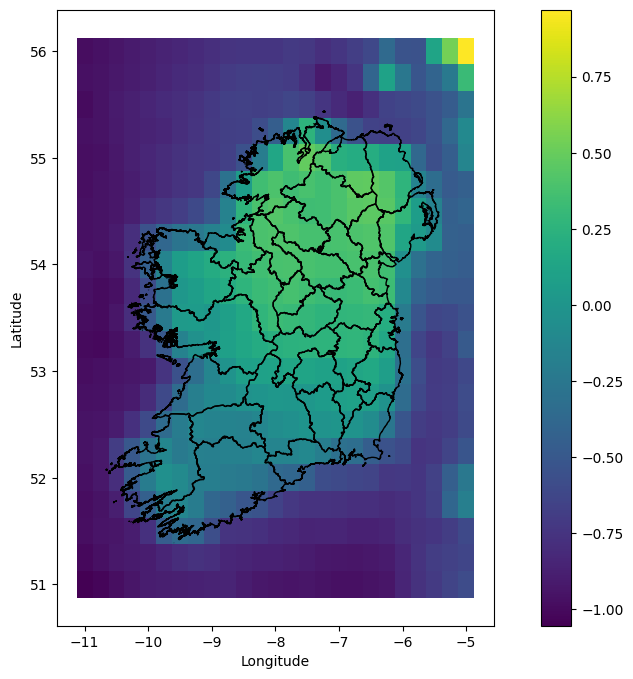

In [180]:
filtered_df = merged_era5_hd_m[merged_era5_hd_m['time'] == '2021-05-01']
#filtered_df = filtered_df.dropna(subset = ['tp'])
# Compute the mean over the step dimension as well
longitudes = filtered_df.longitude.values
latitudes = filtered_df.latitude.values
values = filtered_df['tp'].values
filtered_df = gpd.GeoDataFrame(filtered_df, crs='EPSG:4326')


fig, ax = plt.subplots(figsize=(12, 8))
filtered_df.plot(column='t2m', kind = 'geo',cmap='viridis', legend=True, ax=ax)
county_gdf.plot(ax=ax, facecolor="none", edgecolor='black')  # Adjust colors as needed

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#plt.savefig(r'/Users/dhruvpandit/Mirror/University/Masters/Thesis/images/2017Q3_grid_plot.png' , dpi = 300)

# Show the plot
plt.show()

# Merging ERA5 Data with Municipalities

### Plottingn the Polygon Grid and Points

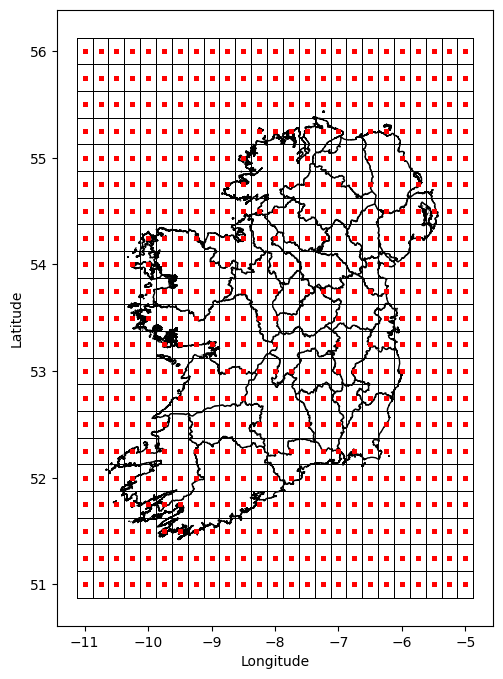

In [182]:
# Plot the polygons
fig, ax = plt.subplots(figsize=(12, 8))
merged_era5_hd_m.boundary.plot(ax=ax, color='black', linewidth=0.5)

county_gdf.plot(ax=ax, color='white', edgecolor='black')
# Overlaying the points
merged_era5_hd_m.points_geometry.plot(ax=ax, marker='o', color='red', markersize=5)  # Adjust marker style as needed

#plt.title('Polygons Based on Dataset Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Obtain List of Unique Polygons From ERA5 Grids

In [183]:
poly_era5 = gpd.GeoDataFrame(data={'geometry':merged_era5_hd_m['geometry'].unique()},geometry='geometry' ,crs='EPSG:4326')

#### Plotting Intersection

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/1039424266.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  results_merge_poly = gpd.overlay(county_gdf, poly_era5, how='intersection')


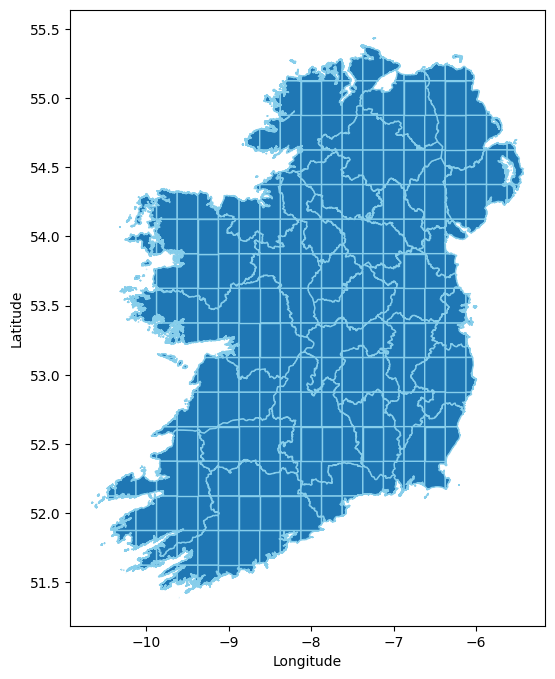

In [184]:


# Assuming `mun_gdf` and `poly_era5` are already defined and are valid GeoDataFrame objects
# Reduce the polygons to just Portugal (intersection of era5 and districts)
results_merge_poly = gpd.overlay(county_gdf, poly_era5, how='intersection')

# Obtain area contribution of each polygon
results_merge_poly['area'] = results_merge_poly.apply(lambda row: row.geometry.area, axis=1)

# Create a larger plot with distinct grid lines
fig, ax = plt.subplots(1, 1, figsize=(12, 8))  # Adjust the figsize to suit your needs

# Plot the merged polygons, specifying the edge color for the municipal boundaries
results_merge_poly.plot(ax=ax, edgecolor='skyblue')  # You can change 'skyblue' to any color you prefer

# Customize grid lines
#ax.grid(True, linestyle='-', color='white', linewidth=0.5)  # You can adjust the color and linewidth as needed
ax.grid(False)
# Optionally, you can also remove the axis for a cleaner look
#ax.set_axis_off()
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')


# Show the plot
plt.show()


### Obtain Polygons to be Joined On
- Here we obtain the era5 polygon grids that fall within portugal so that we can select districts, maintian rows and multindex

In [185]:
county_poly_to_be_join = gpd.overlay(county_gdf,poly_era5, how='intersection')

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/1182302410.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  county_poly_to_be_join = gpd.overlay(county_gdf,poly_era5, how='intersection')


### Merge With STD Data
- Create area columns
- Rename multindex

#### Monthly Data

In [186]:
std_ireland_era5_m = gpd.sjoin(county_poly_to_be_join,merged_era5_std_m, how='inner', predicate='within')
std_ireland_era5_m['area'] =std_ireland_era5_m.apply(lambda row: row.geometry.area,axis=1)
std_ireland_era5_m.set_index(['longitude','latitude', 'time'], inplace = True)


#### Quarterly Data

In [187]:
std_ireland_era5_q = gpd.sjoin(county_poly_to_be_join,merged_era5_std_q, how='inner', predicate='within')
std_ireland_era5_q['area'] =std_ireland_era5_q.apply(lambda row: row.geometry.area,axis=1)
std_ireland_era5_q.set_index(['longitude','latitude', 'time'], inplace = True)

### Merge With HD Data
- Create area columns
- Rename multindex

#### Monthly Data

In [188]:
hd_ireland_era5_m = gpd.sjoin(county_poly_to_be_join,merged_era5_hd_m, how='inner', predicate='within')
hd_ireland_era5_m['area'] =hd_ireland_era5_m.apply(lambda row: row.geometry.area,axis=1)
hd_ireland_era5_m.set_index(['longitude','latitude', 'time'], inplace = True)

#### Quarterly Data

In [189]:
hd_ireland_era5_q = gpd.sjoin(county_poly_to_be_join,merged_era5_hd_q, how='inner', predicate='within')
hd_ireland_era5_q['area'] =hd_ireland_era5_q.apply(lambda row: row.geometry.area,axis=1)
hd_ireland_era5_q.set_index(['longitude','latitude', 'time'], inplace = True)

## Calculate Weighted Value for Each Climate Variable, For Each Group (Municipality)

### Standard Deviations

#### Monthly Data

In [192]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
std_ireland_era5_m_c = std_ireland_era5_m.copy()
std_ireland_era5_m_c['area'] = std_ireland_era5_m_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = std_ireland_era5_m_c.groupby(['NAME_TAG', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
std_ireland_era5_m_c = std_ireland_era5_m_c.merge(area_sum_df_mun, on=['NAME_TAG', 'time'])

# List of variables to process
variables_std = ['t2m', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    std_ireland_era5_m_c[weighted_col_name] = std_ireland_era5_m_c[variable] * (std_ireland_era5_m_c['area'] / std_ireland_era5_m_c['total_area'])

# Group by and sum the weighted values
weighted_std_county_m = std_ireland_era5_m_c.groupby(['NAME_TAG', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/2046640655.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  std_ireland_era5_m_c['area'] = std_ireland_era5_m_c['geometry'].area


#### Quarterly Data

In [193]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
std_ireland_era5_q_c = std_ireland_era5_q.copy()
std_ireland_era5_q_c['area'] = std_ireland_era5_q_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = std_ireland_era5_q_c.groupby(['NAME_TAG', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
std_ireland_era5_q_c = std_ireland_era5_q_c.merge(area_sum_df_mun, on=['NAME_TAG', 'time'])

# List of variables to process
variables_std = ['t2m', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    std_ireland_era5_q_c[weighted_col_name] = std_ireland_era5_q_c[variable] * (std_ireland_era5_q_c['area'] / std_ireland_era5_q_c['total_area'])

# Group by and sum the weighted values
weighted_std_county_q = std_ireland_era5_q_c.groupby(['NAME_TAG', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/3306732529.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  std_ireland_era5_q_c['area'] = std_ireland_era5_q_c['geometry'].area


### Historical Deviations

#### Monthly Data

In [194]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hd_ireland_era5_m_c = hd_ireland_era5_m.copy()
hd_ireland_era5_m_c['area'] = hd_ireland_era5_m_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = hd_ireland_era5_m_c.groupby(['NAME_TAG', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hd_ireland_era5_m_c = hd_ireland_era5_m_c.merge(area_sum_df_mun, on=['NAME_TAG', 'time'])

# List of variables to process
variables_std = ['t2m', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    hd_ireland_era5_m_c[weighted_col_name] = hd_ireland_era5_m_c[variable] * (hd_ireland_era5_m_c['area'] / hd_ireland_era5_m_c['total_area'])

# Group by and sum the weighted values
weighted_hd_county_m = hd_ireland_era5_m_c.groupby(['NAME_TAG', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/386606175.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hd_ireland_era5_m_c['area'] = hd_ireland_era5_m_c['geometry'].area


#### Quarterly Data

In [195]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hd_ireland_era5_q_c = hd_ireland_era5_q.copy()
hd_ireland_era5_q_c['area'] = hd_ireland_era5_q_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = hd_ireland_era5_q_c.groupby(['NAME_TAG', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hd_ireland_era5_q_c = hd_ireland_era5_q_c.merge(area_sum_df_mun, on=['NAME_TAG', 'time'])

# List of variables to process
variables_std = ['t2m', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    hd_ireland_era5_q_c[weighted_col_name] = hd_ireland_era5_q_c[variable] * (hd_ireland_era5_q_c['area'] / hd_ireland_era5_q_c['total_area'])

# Group by and sum the weighted values
weighted_hd_county_q = hd_ireland_era5_q_c.groupby(['NAME_TAG', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_55055/3381300929.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hd_ireland_era5_q_c['area'] = hd_ireland_era5_q_c['geometry'].area


#### Test Plots

In [196]:
test_plot_weighted_mun_std= weighted_std_county_q.loc[pd.IndexSlice[:, '2018Q1', :]]
test_plot_weighted_mun_std = gpd.GeoDataFrame(pd.merge(test_plot_weighted_mun_std, county_gdf,on = 'NAME_TAG'))
test_plot_weighted_mun_std

,NAME_TAG,t2m_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd,OSM_ID,NAME_GA,NAME_EN,geometry
0,Antrim,2.043957,0.983296,120774.821108,0.000149,0.148555,-1119534.0,Contae Aontroma,County Antrim,"MULTIPOLYGON (((-6.66899 55.19835, -6.66879 55..."
1,Armagh,2.402652,1.434204,118084.578210,0.000131,0.131330,-1119535.0,Contae Ard Mhacha,County Armagh,"POLYGON ((-6.87804 54.27924, -6.87778 54.27946..."
2,Carlow,2.728277,1.622257,109954.459753,0.000137,0.136681,-285977.0,Contae Cheatharlach,County Carlow,"POLYGON ((-7.10794 52.72526, -7.10794 52.72538..."
3,Cavan,2.449349,1.523673,116919.532511,0.000134,0.133884,-283679.0,Contae an ChabhÃ¡in,County Cavan,"POLYGON ((-8.05818 54.23621, -8.05818 54.23634..."
4,Clare,2.554020,1.476710,113606.342443,0.000154,0.153892,-334885.0,Contae an ChlÃ¡ir,County Clare,"MULTIPOLYGON (((-9.93876 52.55966, -9.93842 52..."
5,Cork,2.537488,1.384544,108915.485278,0.000178,0.177771,-332631.0,Contae ChorcaÃ­,County Cork,"MULTIPOLYGON (((-10.16216 51.58390, -10.16207 ..."
6,Donegal,2.132507,1.096710,121610.620093,0.000180,0.180046,-283732.0,Contae DhÃºn na nGall,County Donegal,"MULTIPOLYGON (((-8.80575 54.69859, -8.80572 54..."
7,Down,2.108940,0.965490,118719.922275,0.000155,0.155454,-1119533.0,Contae an DÃºin,County Down,"MULTIPOLYGON (((-6.40037 54.39330, -6.40035 54..."
8,Dublin,2.353149,1.310474,113456.912493,0.000137,0.136854,-282800.0,Contae Ãtha Cliath,County Dublin,"MULTIPOLYGON (((-6.54689 53.27948, -6.54642 53..."
9,Fermanagh,2.382791,1.438832,118458.281625,0.000150,0.150432,-1118085.0,Contae Fhear Manach,County Fermanagh,"POLYGON ((-8.17751 54.46476, -8.17711 54.46500..."


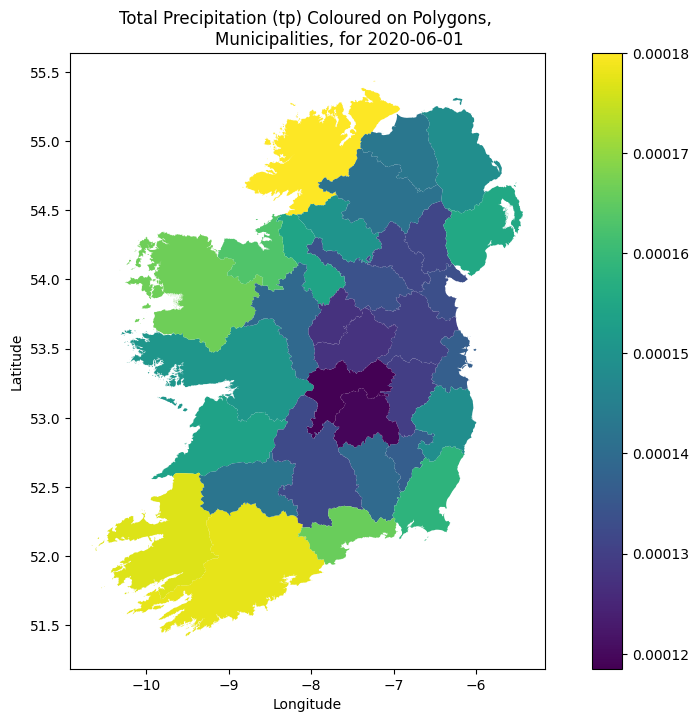

In [197]:
fig, ax = plt.subplots(figsize=(12, 8))
test_plot_weighted_mun_std.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
ax.set_title('''Total Precipitation (tp) Coloured on Polygons, 
            Municipalities, for 2020-06-01''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

## Convert To Excel Data

### Things to Consider Before Saving
1. **Is your economic data indexed on a different county ID?** Then you need to specify this, and perform a pd.merge with the county_gdf column it is indexed on (the data below only considers the county name_tag for eg Wicklow)
2. **Do you need a different index for your time?** You need to reformat the index then, following the steps outlined in the cells Reindex Data Index. 

In [201]:
weighted_hd_mun_m_excel = weighted_hd_county_m.reset_index()
weighted_hd_mun_q_excel = weighted_hd_county_q.reset_index()
weighted_std_mun_m_excel = weighted_std_county_m.reset_index()
weighted_std_mun_q_excel = weighted_std_county_q.reset_index()

In [202]:
weighted_hd_mun_m_excel.to_excel(r'../../../countries/ireland/datasets/era5/weighted_hist_dev_county_m.xlsx')
weighted_hd_mun_q_excel.to_excel(r'../../../countries/ireland/datasets/era5/weighted_hist_dev_mun_q.xlsx')
weighted_std_mun_m_excel.to_excel(r'../../../countries/ireland/datasets/era5/weighted_std_county_m.xlsx')
weighted_std_mun_q_excel.to_excel(r'../../../countries/ireland/datasets/era5/weighted_std_county_q.xlsx')